In [1]:
import emoji
import locale
import sqlite3
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

### Utilities

In [2]:
def load_from_database(
        db: str,
        table: str,
        columns: str,
):
    connection = sqlite3.connect('../database/' + db + '.db')
    df = pd.read_sql_query(
        str('SELECT ' + columns + ' FROM ' + table), con=connection
    )
    connection.close()
    return df


def save_to_database(
        db: str,
        table: str,
        df: pd.DataFrame
):
    connection = sqlite3.connect('../database/' + db + '.db')
    try:
        df.to_sql(name=table, con=connection, if_exists='replace')
    except Exception as e:
        raise e
    print('DataFrame has been saved successfully to: ' + db)

In [3]:
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Palatino'
fig_path = r'/Users/leonbecker/Library/CloudStorage/OneDrive-UniversitätWürzburg/Universität Würzburg/Master Information-Systems/Thesis/LaTex/graphics/'
plt.rcParams['path.simplify'] = True
locale.setlocale(locale.LC_NUMERIC, "de_DE")
plt.rcParams['axes.formatter.use_locale'] = True

In [ ]:
wine_type_ids = {
    1: 'Rotwein',
    2: 'Weißwein',
    3: 'Schaumwein',
    4: 'Rosé',
    24: 'Likörwein',
    7: 'Dessertwein'
}

In [ ]:
con_wine = sqlite3.connect('../database/wine_distinct.db')
df_wine = pd.read_sql_query("SELECT * from wine_distinct", con_wine)
df_wine.head()

In [ ]:
for index in df_wine.index:
    df_wine.at[index, 'type_name'] = wine_type_ids[df_wine.loc[index, 'type_id']]

In [ ]:
ax = df_wine.country.value_counts().head(n=10).plot(
    kind='bar',
    color='black',
    zorder=3
)
plt.grid(zorder=0, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_path + 'top_10_producer_countries.pdf')

In [ ]:
ax = df_wine.type_name.value_counts().plot(
    kind='bar',
    color='black',
    zorder=3
)
plt.grid(zorder=0, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_path + 'wine_type_distribution.pdf')

In [ ]:
ax = df_wine.average_rating.plot(
    kind='box'
)
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
plt.savefig(fig_path + 'average_rating.pdf')

In [ ]:
ax = df_wine.boxplot(by='type_name', column='average_rating', rot=45)
ax.set_title('')
plt.suptitle('')
ax.set_xlabel('')
plt.tight_layout()
plt.xticks(rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig(fig_path + 'average_rating_by_wine.pdf')

In [ ]:
top_10_countries = df_wine.country.value_counts().head(n=10).index

In [ ]:
plt.grid(zorder=0)
ax = sb.violinplot(
    data=df_wine[df_wine.country.isin(top_10_countries)],
    y='average_rating',
    x='country',
    #palette=['w','w','w','w', 'w','w','w','w', 'w', 'w'],
    zorder=3
)
# plt.grid(axis='y')
plt.xticks(rotation=45)
plt.ylabel(None)
plt.xlabel(None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path + 'top_10_ratings_for_countries.pdf')

# Reviews

In [3]:
con_rev = sqlite3.connect('../database/review.db')
df_rev = pd.read_sql_query("SELECT * from review", con_rev)
df_rev.head()

,index,id,wine_id,rating,note,created_at,likes_count,comments_count,scan_image_path,user_id,note_length,len_code
0,0,66,1154225,3.5,notevole differenza tra naso e palato. con spi...,1969-12-31T23:00:01.000Z,1.0,0.0,images.vivino.com/labels/01dls5mm5nr12.jpg,4683161,18,it
1,1,2996,1652,5.0,toskaner auf absoluten top-niveau. einer der b...,2011-04-17T19:53:55.000Z,1.0,2.0,images.vivino.com/thumbs/LtqnB-H2QFmN6ixL3FQcd...,24294,18,de
2,2,3975,1101258,4.0,excellent full bodied wine,2011-07-19T21:21:22.000Z,2.0,1.0,images.vivino.com/labels/1309631550_2382.jpg,32547,4,en
3,3,4202,76378,5.0,the real price at phillipson is around 1299 dk...,2011-08-06T20:52:53.000Z,0.0,1.0,images.vivino.com/labels/1311959128_1819.jpg,48500,39,en
4,4,4261,1231210,5.0,"clean, crisp and full of nuance and elegance, ...",2011-08-11T08:06:39.000Z,3.0,1.0,images.vivino.com/labels/1312622458_6592.jpg,53601,17,en


In [4]:
df_rev['created_at'] = pd.to_datetime(df_rev.created_at)
df_rev = df_rev[1:]

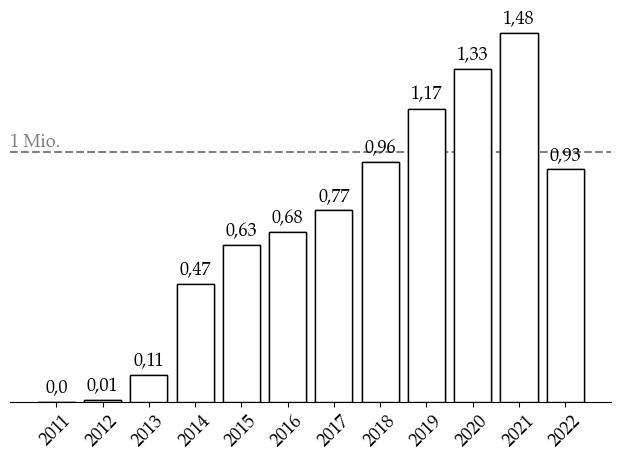

In [106]:
year_count = df_rev.groupby(df_rev.created_at.dt.year).count()
fig, ax = plt.subplots()
ax.axhline(y=1000000, linestyle='--', color='grey', label='1 Mio.')
plt.annotate(xy=(2010, 1020000), text='1 Mio.', color='grey')
ax.bar(
    x=df_rev.groupby(df_rev.created_at.dt.year).count().index,
    height=df_rev.groupby(df_rev.created_at.dt.year).count().created_at,
    edgecolor='black',
    color='white',
    zorder=3
)
ax.set_xticks(list(df_rev.groupby(df_rev.created_at.dt.year).count().index))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
plt.xticks(rotation=45)
container = ax.containers[0]
bars = ax.bar(year_count.index.to_list(),
              [item for sublist in df_rev.groupby(df_rev.created_at.dt.year).count().values.tolist() for item in
               sublist],
              edgecolor='black', color='white')
ax.bar_label(container,
             labels=[str.replace(str(np.round(x / 1000000, decimals=2)), '.', ',') for x in container.datavalues],
             padding=3)
plt.tight_layout()
fig.savefig(fig_path + 'yearly_reviews.pdf')

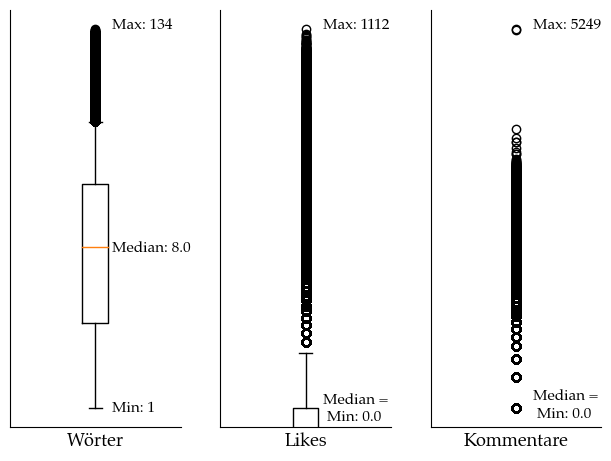

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.boxplot(
    df_rev.note_length,
    positions=[0.8]
)
ax2.boxplot(
    df_rev.likes_count,
    positions=[0.8]
)
ax3.boxplot(
    df_rev.comments_count,
    positions=[0.8]
)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax1.annotate('Max: ' + str(int(df_rev.note_length.max())), (0.9, df_rev.note_length.max()), fontsize=11)
ax1.annotate('Min: ' + str(df_rev.note_length.min()), (0.9, df_rev.note_length.min() - 0.05), fontsize=11)
ax1.annotate('Median: ' + str(df_rev.note_length.median()), (0.9, df_rev.note_length.median() - 0.5), fontsize=11)

ax2.annotate('Max: ' + str(int(df_rev.likes_count.max())), (0.9, df_rev.likes_count.max()), fontsize=11)
ax2.annotate('Median =\n Min: ' + str(df_rev.likes_count.min()), (0.9, df_rev.likes_count.min() + 1.6), fontsize=11)

ax3.annotate('Max: ' + str(int(df_rev.comments_count.max())), (0.9, df_rev.comments_count.max()), fontsize=11)
ax3.annotate('Median =\n Min: ' + str(df_rev.likes_count.min()), (0.9, df_rev.likes_count.min() + 0.8), fontsize=11)

ax1.tick_params(axis=u'both', which=u'both', length=0, labelbottom=False)
ax2.tick_params(axis=u'both', which=u'both', length=0, labelbottom=False)
ax3.tick_params(axis=u'both', which=u'both', length=0, labelbottom=False)

ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.set_xlabel('Wörter')
ax2.set_xlabel('Likes')
ax3.set_xlabel('Kommentare')

fig.tight_layout()
fig.savefig(fig_path + 'stats_reviews.png', dpi=300)

In [10]:
len(df_rev[df_rev.comments_count == 0]) / len(df_rev)

0.8932806500428416

In [ ]:
ax = df_rev.groupby([pd.to_datetime(df_rev.created_at).dt.date.drop(0)]).count()['index'].cumsum().plot()

In [ ]:
# convert date column to datetime and subtract one week
df_rev['created_at'] = pd.to_datetime(df_rev['created_at']) - pd.to_timedelta(7, unit='d')

# calculate sum of values, grouped by week
ax = df_rev.groupby([pd.Grouper(key='created_at', freq='W')]).count()['index'].cumsum().plot()

In [ ]:
ax = df_rev.groupby([pd.Grouper(key='created_at', freq='W')])['index'].count().cumsum().plot()

In [ ]:
df_rev.groupby([pd.to_datetime(df_rev.created_at).dt.date.drop(0)])

In [ ]:
print(ax)

In [ ]:
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.get_figure().tight_layout()
ax.get_figure().savefig(fig_path + '/cumsum_reviews_month.pdf')

In [ ]:
pd.to_datetime(df_rev.created_at).dt.date.drop(0, inplace=True)

In [ ]:
data_var = df_rev.len_code.value_counts().head(n=10)
data_var.index = ['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                  'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch']
data_var

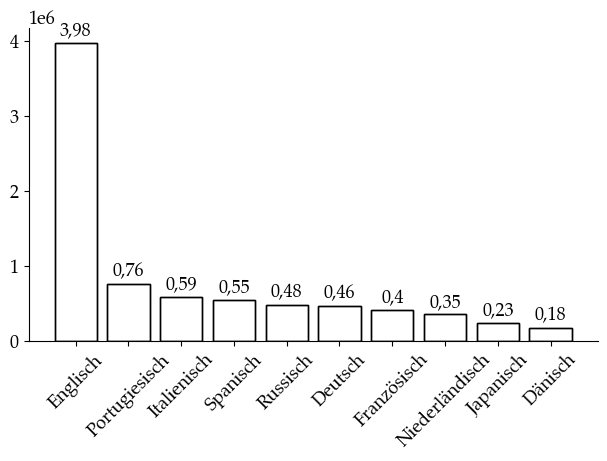

In [15]:
data_var = df_rev.len_code.value_counts().head(n=10)
data_var.index = ['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                  'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch']
fig, ax = plt.subplots()
ax.bar(
    x=data_var.index,
    height=data_var.values,
    edgecolor='black', color='none'
)
plt.xticks(rotation=45)
bars = ax.bar(data_var.index,
              data_var.values,
              edgecolor='black', color='none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
container = ax.containers[0]
ax.bar_label(container,
             labels=[str.replace(str(np.round(x / 1000000, decimals=2)), '.', ',') for x in container.datavalues],
             padding=2)
# ax.bar_label(bars, padding=3)
fig.tight_layout()
fig.savefig(fig_path + 'language_distribution.pdf')

In [9]:
top_10_order = list(df_rev.len_code.value_counts().head(n=10).index)
top_10_order

['en', 'pt', 'it', 'es', 'ru', 'de', 'fr', 'nl', 'ja', 'da']

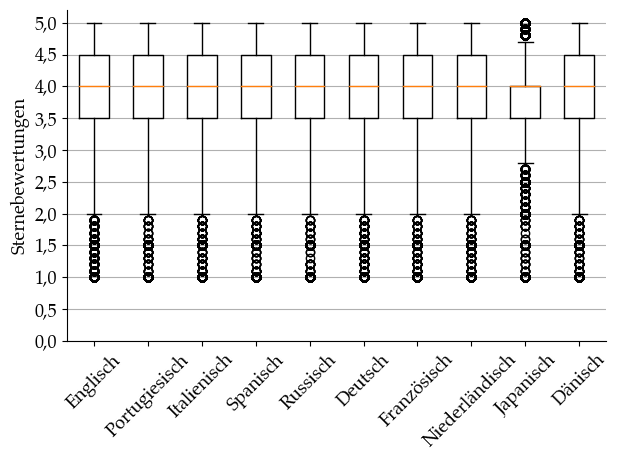

In [14]:
fig, ax = plt.subplots()
df = df_rev[df_rev.len_code.isin(top_10_order)][['len_code', 'rating']]
for position, column in enumerate(top_10_order):
    plot_var = ax.boxplot(df[df.len_code == column].rating, positions=[position], widths=0.55)

ax.set_xticks(range(position + 1))
ax.set_xticklabels(top_10_order)
# ax.set_xlim(xmin=-0.5)
ax.set_xticklabels(['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                    'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch'])
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_ylabel('Sternebewertungen')
ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.tight_layout()
plt.show()
fig.savefig(fig_path + 'top_10_review_count_ratings.png', dpi=300)

In [9]:
con_rev_sent = sqlite3.connect('../database/review_en_sentiment.db')
df_rev_sent = pd.read_sql_query("SELECT id, rating, sentiment, note_length, note FROM review_en_sentiment",
                                con_rev_sent)
df_rev_sent.head()

,id,rating,sentiment,note_length,note
0,3975,4.0,0.938549,4,excellent full bodied wine
1,4202,5.0,0.576068,39,the real price at phillipson is around 1299 dk...
2,4261,5.0,0.982237,17,"clean, crisp and full of nuance and elegance, ..."
3,4264,4.0,0.576195,22,"crisp and clean champagne, a certain fave amon..."
4,4354,4.0,0.736812,12,it is not a champagne type wine! it is a red w...


In [10]:
n = 25000
df = df_rev_sent.sample(n=n)

In [38]:
correct_sent = {
    1.0: -1.0,
    1.5: -0.75,
    2.0: -0.5,
    2.5: -0.25,
    3.0: 0,
    3.5: 0.25,
    4.0: 0.5,
    4.5: 0.75,
    5.0: 1
}

df_correct = pd.DataFrame()

for rating in correct_sent.keys():
    sent = correct_sent[rating]
    df_correct = pd.concat([df_correct, df[(df.rating == rating) & ((df.sentiment <= sent + 0.1) & (df.sentiment >= sent - 0.1))]])
df_correct.head()

,id,rating,sentiment,note_length,note
993731,65296517,1.0,-0.911612,6,"disappointing, strange and too intense. metallic."
2809782,185149095,1.0,-0.913273,7,"must have gone bad, this is terrible"
1280744,84840417,1.0,-0.933147,25,"this has no qualities of a cab whatsoever, it ..."
2678229,176426302,1.0,-0.911104,5,shitty wine with low quality
245063,18372830,1.0,-0.924342,8,unfortunately the wine was too old......damn d...


In [39]:
df_incorrect = df[~df.id.isin(df_correct.id)]
df_incorrect.head()

,id,rating,sentiment,note_length,note
3925491,253706325,3.0,-0.528974,26,"medium pink color, hint of orange. nose of ove..."
2380679,156629697,4.5,0.963727,15,"wine evenings with friends leather, oak, cedar..."
544534,35884335,4.0,0.956674,2,delicious wine
2835285,186828812,3.5,0.868941,8,a good spicy blend with red fruit dominance.
1004547,66012348,4.0,0.601349,19,need to let it breath for awhile. first taste ...


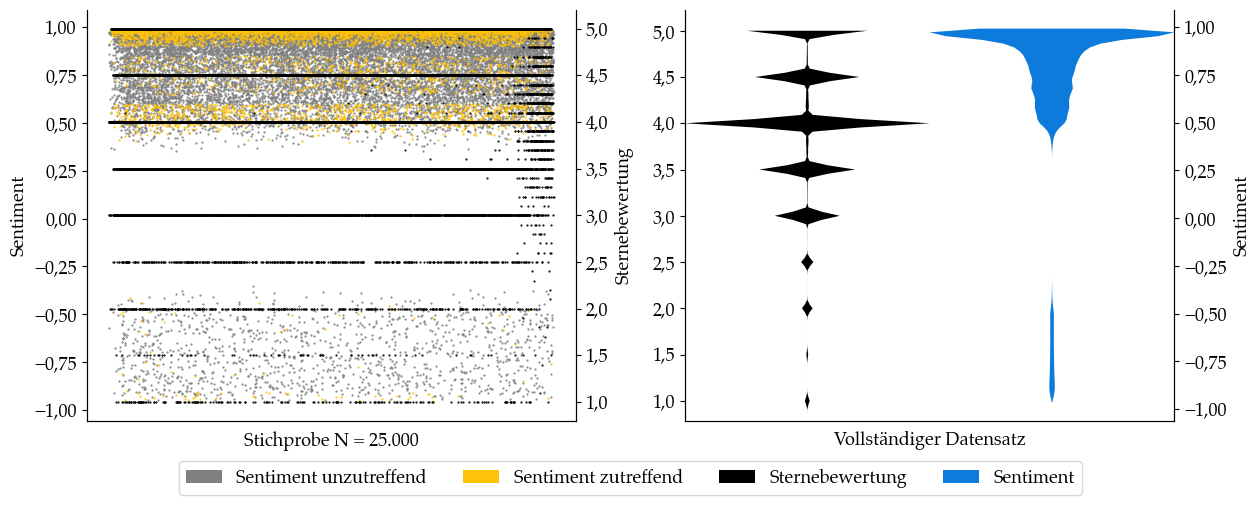

In [57]:
from matplotlib.patches import Patch

# Initialize subplots
fig, (ax1_1, ax2_1) = plt.subplots(nrows=1, ncols=2, figsize=(12.8, 4.8))

# First plot
ax1_2 = ax1_1.twinx()
ax1_1.scatter(x=df_incorrect.id, y=df_incorrect.sentiment, c='grey', s=0.3)
ax1_1.scatter(x=df_correct.id, y=df_correct.sentiment, c='#FFC20A', s=0.3)
ax1_2.scatter(x=df.id, y=df.rating, c='black', s=0.3)
ax1_1.set_ylabel('Sentiment')
ax1_2.set_ylabel('Sternebewertung')
ax1_2.set_xticks([])
ax1_1.set_xticklabels([])
ax1_1.set_xlabel('Stichprobe N = 25.000')
ax1_1.spines['top'].set_visible(False)
ax1_2.spines['top'].set_visible(False)

# Second plot
ax2_2 = ax2_1.twinx()
p1 = ax2_1.violinplot(df_rev_sent.rating, positions=[0.5], showextrema=False)
p2 = ax2_2.violinplot(df_rev_sent.sentiment, positions=[1], showextrema=False)

for pc in p1['bodies']:
    pc.set_facecolor('black')
    pc.set_alpha(1)
for pc in p2['bodies']:
    pc.set_facecolor('#0C7BDC')
    pc.set_alpha(1)
ax2_1.spines['top'].set_visible(False)
ax2_2.spines['top'].set_visible(False)

ax2_1.set_xlim(0.25, 1.25)
ax2_1.set_xticks([])
ax2_1.set_ylim(ymin=0.785)

ax2_2.set_ylabel('Sentiment')
ax2_1.set_xlabel('Vollständiger Datensatz')

legened_elements = [
    Patch(facecolor='grey', label='Sentiment unzutreffend'),
    Patch(facecolor='#FFC20A', label='Sentiment zutreffend'),
    Patch(facecolor='black', label='Sternebewertung'),
    Patch(facecolor='#0C7BDC', label='Sentiment')
]

fig.legend(handles=legened_elements, loc='lower center', bbox_to_anchor=(0.25, -0.07, 0.5, 0.5), ncol=4)
fig.tight_layout()
fig.savefig(fig_path + 'sentiment_rating.png', bbox_inches='tight', dpi=400)

In [58]:
print('Min: ' + str(df_incorrect.note_length.min()))
print('Median: ' + str(df_incorrect.note_length.median()))
print('Mean: ' + str(df_incorrect.note_length.mean()))
print('Max: ' + str(df_incorrect.note_length.max()))
print('\n')
print('Min: ' + str(df_correct.note_length.min()))
print('Median: ' + str(df_correct.note_length.median()))
print('Mean: ' + str(df_correct.note_length.mean()))
print('Max: ' + str(df_correct.note_length.max()))

Min: 1
Median: 9.0
Mean: 15.53471304858359
Max: 106


Min: 1
Median: 7.0
Mean: 12.819337864503398
Max: 97


In [60]:
len(df_incorrect)

20439

In [52]:
print(df_correct[df_correct.rating <= 2].note_length.median())
print(df_incorrect[df_incorrect.rating <= 2].note_length.median())

8.0
7.0


In [3]:
con_rev_en_sent = sqlite3.connect('../database/review_en_sentiment.db')
df_rev_en_sent = pd.read_sql_query("SELECT * FROM review_en_sentiment", con_rev_en_sent)
df_rev_en_sent.head()

,index,id,wine_id,rating,note,created_at,likes_count,comments_count,scan_image_path,user_id,note_length,len_code,sentiment
0,0,3975,1101258,4.0,excellent full bodied wine,2011-07-19T21:21:22.000Z,2.0,1.0,images.vivino.com/labels/1309631550_2382.jpg,32547,4,en,0.938549
1,1,4202,76378,5.0,the real price at phillipson is around 1299 dk...,2011-08-06T20:52:53.000Z,0.0,1.0,images.vivino.com/labels/1311959128_1819.jpg,48500,39,en,0.576068
2,2,4261,1231210,5.0,"clean, crisp and full of nuance and elegance, ...",2011-08-11T08:06:39.000Z,3.0,1.0,images.vivino.com/labels/1312622458_6592.jpg,53601,17,en,0.982237
3,3,4264,1178663,4.0,"crisp and clean champagne, a certain fave amon...",2011-08-11T09:28:07.000Z,25.0,2.0,images.vivino.com/labels/1312966707_6129.jpg,53601,22,en,0.576195
4,4,4354,17998,4.0,it is not a champagne type wine! it is a red w...,2011-08-12T16:53:19.000Z,0.0,1.0,images.vivino.com/labels/1311842730_8268.jpg,47873,12,en,0.736812


In [3]:
emojis = [c for c in df_rev_en_sent.note if c in emoji.EMOJI_DATA]
emojis.sort()
emoji_frequency = Counter(emojis)
emoji_frequency = {k: v for k, v in sorted(emoji_frequency.items(), key=lambda item: item[1])}
emoji_frequency

{'↗': 1,
 '⏱': 1,
 '☘': 1,
 '☘️': 1,
 '☯️': 1,
 '☹': 1,
 '⚠️': 1,
 '✌🏿': 1,
 '🇨🇭': 1,
 '🇭🇷': 1,
 '🇸🇮': 1,
 '🌃': 1,
 '🌅': 1,
 '🌈': 1,
 '🌚': 1,
 '🌩': 1,
 '🌰': 1,
 '🌱': 1,
 '🌵': 1,
 '🍗': 1,
 '🍜': 1,
 '🍦': 1,
 '🍸': 1,
 '🎅': 1,
 '🎅🏿': 1,
 '🎨': 1,
 '🏊': 1,
 '🏯': 1,
 '🏴\U000e0067\U000e0062\U000e0077\U000e006c\U000e0073\U000e007f': 1,
 '🐈': 1,
 '🐞': 1,
 '🐢': 1,
 '🐥': 1,
 '🐦': 1,
 '🐵': 1,
 '🐸': 1,
 '🐽': 1,
 '👆🏻': 1,
 '👈🏻': 1,
 '👞': 1,
 '👨🏻\u200d💻': 1,
 '👨🏿\u200d🎨': 1,
 '👼': 1,
 '💁🏻': 1,
 '💪🏿': 1,
 '🖖': 1,
 '🖖🏼': 1,
 '🖖🏾': 1,
 '🚑': 1,
 '🚬': 1,
 '🛂': 1,
 '🤎': 1,
 '🤴🏻': 1,
 '🤸': 1,
 '🥀': 1,
 '🥝': 1,
 '\U0001f977🏻': 1,
 '🦁': 1,
 '🦌': 1,
 '🦒': 1,
 '🦮': 1,
 '🧁': 1,
 '🧮': 1,
 '🩳': 1,
 '\U0001faa8': 1,
 '\U0001faf6': 1,
 '✌🏾': 2,
 '🍀': 2,
 '🍰': 2,
 '🎩': 2,
 '🏺': 2,
 '🐚': 2,
 '🐯': 2,
 '👁': 2,
 '👩🏼\u200d🤝\u200d👨🏿': 2,
 '💅🏻': 2,
 '💰': 2,
 '🔞': 2,
 '🖐': 2,
 '🗡': 2,
 '😤': 2,
 '🤏': 2,
 '🥤': 2,
 '\U0001f979': 2,
 '🦀': 2,
 '🦧': 2,
 '\U0001faf6🏻': 2,
 '🇦🇷': 3,
 '🎂': 3,
 '🏅': 3,
 '🐂': 3,
 '💎': 3,
 '💐': 3,
 '💪🏾':

In [4]:
df_emoji = pd.DataFrame(
    {
        'emoji': ['👍', '😍', '👌', '🍷', '🤩', '🥂', '♥️', '😘', '😁', '💪'],
        'count': [1564, 958, 566, 379, 254, 228, 176, 145, 127, 73]
    }
)
for index in df_emoji.index:
    name = emoji.demojize(df_emoji.emoji[index]).replace(':', '').replace('_', ' ')
    df_emoji.loc[index, 'name'] = name
    words = name.split()
    initials = ''
    for word in words:
        initials += word[0]
    df_emoji.loc[index, 'initials'] = initials.upper()

df_emoji.head()

,emoji,count,name,initials
0,👍,1564,thumbs up,TU
1,😍,958,smiling face with heart-eyes,SFWH
2,👌,566,OK hand,OH
3,🍷,379,wine glass,WG
4,🤩,254,star-struck,S


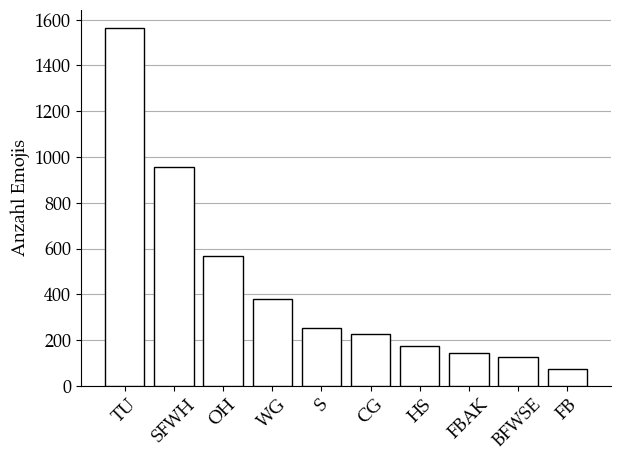

In [151]:
fig, ax = plt.subplots()
ax.bar(
    x=df_emoji.initials,
    height=df_emoji['count'],
    color='white',
    edgecolor='black',
    zorder=3
)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_ylabel('Anzahl Emojis')
plt.tight_layout()
fig.savefig(fig_path + 'en_emojis_count.pdf')

In [5]:
for index in df_emoji.index:
    cols = df_rev_en_sent[df_rev_en_sent.note.str.contains(df_emoji['emoji'][index])][['sentiment', 'rating']]
    df_emoji.loc[index, 'sentiment'] = cols['sentiment'].mean()
    df_emoji.loc[index, 'rating'] = cols['rating'].mean()
df_emoji

,emoji,count,name,initials,sentiment,rating
0,👍,1564,thumbs up,TU,0.903300,4.178832
1,😍,958,smiling face with heart-eyes,SFWH,0.931466,4.515950
2,👌,566,OK hand,OH,0.914132,4.298683
3,🍷,379,wine glass,WG,0.851377,4.153922
4,🤩,254,star-struck,S,0.942198,4.443710
5,🥂,228,clinking glasses,CG,0.890130,4.049958
6,♥️,176,heart suit,HS,0.930766,4.547641
7,😘,145,face blowing a kiss,FBAK,0.905663,4.322985
8,😁,127,beaming face with smiling eyes,BFWSE,0.881481,4.085305
9,💪,73,flexed biceps,FB,0.871469,4.292006


In [8]:
df_emoji.to_csv('/Users/leonbecker/Desktop/emoji_dataframe.csv')

In [6]:
df_rev_en_sent.created_at[0]

'2011-07-19T21:21:22.000Z'

In [25]:
df_rev_en_sent = load_from_database(db='review_en_sentiment', table='review_en_sentiment', columns='user_id, wine_id')
var_min = 5
var_max = 400
five_to_x_user = df_rev_en_sent[df_rev_en_sent['user_id'].isin(df_rev_en_sent['user_id'].value_counts()[
                                                                   (df_rev_en_sent[
                                                                        'user_id'].value_counts() >= var_min) &
                                                                   (df_rev_en_sent['user_id'].value_counts() <= var_max)
                                                                   ].index)]['user_id']

df_temp = df_rev_en_sent[df_rev_en_sent['user_id'].isin(five_to_x_user)]
minimum_5_wines = df_temp[df_temp['wine_id'].isin(
    df_temp['wine_id'].value_counts()[df_temp['wine_id'].value_counts() >= var_min].index)]['wine_id']
five_to_x_user.drop_duplicates(inplace=True)
minimum_5_wines.drop_duplicates(inplace=True)

/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_35548/3060933970.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_to_x_user.drop_duplicates(inplace=True)
/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_35548/3060933970.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minimum_5_wines.drop_duplicates(inplace=True)


In [26]:
df_rev_en_sent = df_rev_en_sent[
    (df_rev_en_sent['user_id'].isin(five_to_x_user)) &
    (df_rev_en_sent['wine_id'].isin(minimum_5_wines))
    ]
# df_rev_en_sent.drop(columns=['created_at', 'scan_image_path'], inplace=True)

In [27]:
from sklearn.model_selection import train_test_split
test, train = train_test_split(df_rev_en_sent, test_size=0.8, random_state=26)

In [28]:
from multiprocessing_scripts import count_corresponding_reviews
import concurrent.futures

df_rev = pd.concat([test, train])
core_count = 10
df_results = pd.DataFrame()
user_ids = df_rev['user_id']
user_ids.drop_duplicates(inplace=True)
len_user_ids = int(len(user_ids) / core_count)
user_ids_frames = [user_ids.iloc[i * len_user_ids:(i + 1) * len_user_ids].copy() for i in range(core_count + 1)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [
        executor.submit(count_corresponding_reviews.count_corresponding_reviews, [train, test, user_ids_frames[i]]) for i in
        range(core_count)]

    for result in concurrent.futures.as_completed(results):
        df_results = pd.concat([df_results, result.result()])

In [29]:
print('user count: ', str(len(df_rev['user_id'].unique())))
print('wine count: ', str(len(df_rev['wine_id'].unique())))
print('corresponding_reviews: ', str(df_results['corresponding_reviews'].sum()))
print('corresponding_reviews_evaluation: ',str(df_results['corresponding_reviews_evaluation'].sum()))
print('User considered in evaluation: ', str(len(df_rev['user_id'].unique()) -
                                             len(df_results[df_results['corresponding_reviews_evaluation']==0])))

user count:  131921
wine count:  10816
corresponding_reviews:  2010345132
corresponding_reviews_evaluation:  147199186
User considered in evaluation:  111644


In [30]:
111644/131921

0.8462943731475656

In [8]:
df_rev['user_id'].value_counts()

2867095     1513
1566432     1114
3443509     1094
10220990    1063
6812754     1013
            ... 
4641528        4
1666001        4
33082861       4
7366954        4
6831535        4
Name: user_id, Length: 132150, dtype: int64

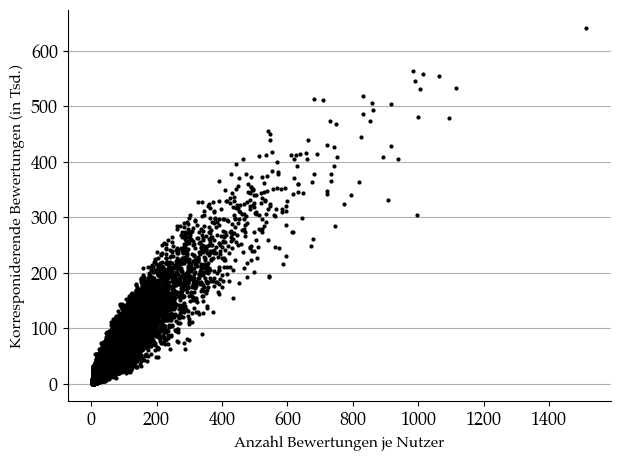

In [7]:
fig, ax = plt.subplots()
ax.scatter(
    x=df_results['reviews_count'],
    y=df_results['corresponding_reviews'] / 1000,
    zorder=3,
    c='black',
    s=4
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xlabel('Anzahl Bewertungen je Nutzer', fontsize=11)
ax.set_ylabel('Korresponiderende Bewertungen (in Tsd.)', fontsize=11)
plt.tight_layout()

fig.savefig(fig_path + 'korrespondierende_bewertung.png', dpi=400)

1171115118

In [12]:
intersection = list(set(df_en_train['user_id']) & set(df_en_test['user_id']))

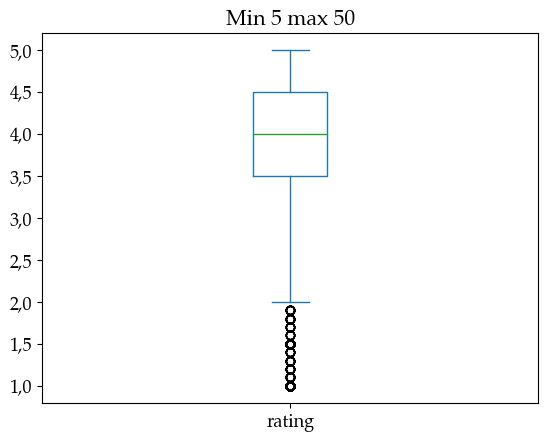

In [13]:
pd.concat([df_en_train[df_en_train['user_id'].isin(intersection)], df_en_test[df_en_test['user_id'].isin(intersection)]]).plot(
    kind='box',
    title='Min 5 max 50',
    y='rating'
)
plt.savefig(fig_path + 'Min 5 max 50.pdf')

In [10]:
pd.concat([df_en_train[df_en_train['user_id'].isin(intersection)], df_en_test[df_en_test['user_id'].isin(intersection)]])

,user_id,wine_id,rating
0,9834827,6020,4.5
1,18567062,1571152,4.0
2,31205049,88008,4.0
3,1186276,3873573,4.0
4,4922852,82729,4.0
...,...,...,...
473086,13004943,73759,3.5
473087,22794732,15615,4.0
473088,13807358,1298777,4.0
473089,31914820,1713612,5.0
